In [1]:
import torch
from torchvision import datasets, transforms
import numpy as np
from matplotlib import pyplot as plt
from utils import plot_tsne
import numpy as np
import random
import argparse
from AutoEncoderDecoder import EncoderCIFAR, DecoderCIFAR, ClassifierCIFAR
from torch.utils.data import Dataset, DataLoader, random_split

In [2]:
# Argument parser for command-line arguments
def get_args():
    parser = argparse.ArgumentParser()
    parser.add_argument('--seed', default=0, type=int, help='Seed for random number generators')
    parser.add_argument('--data-path', default="~/datasets/cv_datasets/data", type=str, help='Path to dataset')
    parser.add_argument('--batch-size', default=8, type=int, help='Size of each batch')
    parser.add_argument('--latent-dim', default=128, type=int, help='Encoding dimension')
    parser.add_argument('--device', default='cuda' if torch.cuda.is_available() else 'cpu', type=str, help='Default device to use')
    parser.add_argument('--mnist', action='store_true', default=False, help='Use MNIST (True) or CIFAR10 (False) data')
    parser.add_argument('--self-supervised', action='store_true', default=False, help='Train self-supervised or jointly with classifier')
    parser.add_argument('--debug', action='store_true', default=False, help='Enable debugging for dataloader')
    args, unknown =  parser.parse_args()
    return args

NUM_CLASSES = 10

In [3]:
def freeze_seeds(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

In [4]:
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ])

In [5]:
freeze_seeds(0)

In [6]:
import os
current_dir = os.getcwd()
train_dataset = datasets.CIFAR10(root=current_dir, train=True, download=True, transform=transform)
class_names = train_dataset.classes 
test_dataset = datasets.CIFAR10(root=current_dir, train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [7]:
# Function to rescale images back from [-1, 1] to [0, 1]
def rescale_image(image):
    return np.clip((image + 1) / 2, 0, 1)  # Rescale from [-1, 1] to [0, 1]

# Function to plot reconstructed images (rescale after reconstruction)
def plot_reconstruction(original, reconstructed, num_images=10):
    original = original.cpu().detach().numpy()
    reconstructed = reconstructed.cpu().detach().numpy()
    
    # Rescale images to [0, 1] range for visualization
    original = rescale_image(original)
    reconstructed = rescale_image(reconstructed)
    num_images = min(num_images, original.shape[0])  # Ensure we don't exceed batch size
    fig, axes = plt.subplots(num_images, 2, figsize=(10, 20))

    for i in range(num_images):
        ax = axes[i, 0]
        ax.imshow(np.transpose(original[i], (1, 2, 0)))  # Reorder dimensions to (H, W, C)
        ax.set_title('Original')
        ax.axis('off')

        ax = axes[i, 1]
        ax.imshow(np.transpose(reconstructed[i], (1, 2, 0)))
        ax.set_title('Reconstructed')
        ax.axis('off')

    plt.show()
    

/Users/mayanrivlin/anaconda3/lib/python3.10/site-packages/torchvision/transforms/functional.py:79: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(pic.tobytes()))


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Epoch 1, Loss: 0.0651582869566977
Test Reconstruction Loss: 0.0455


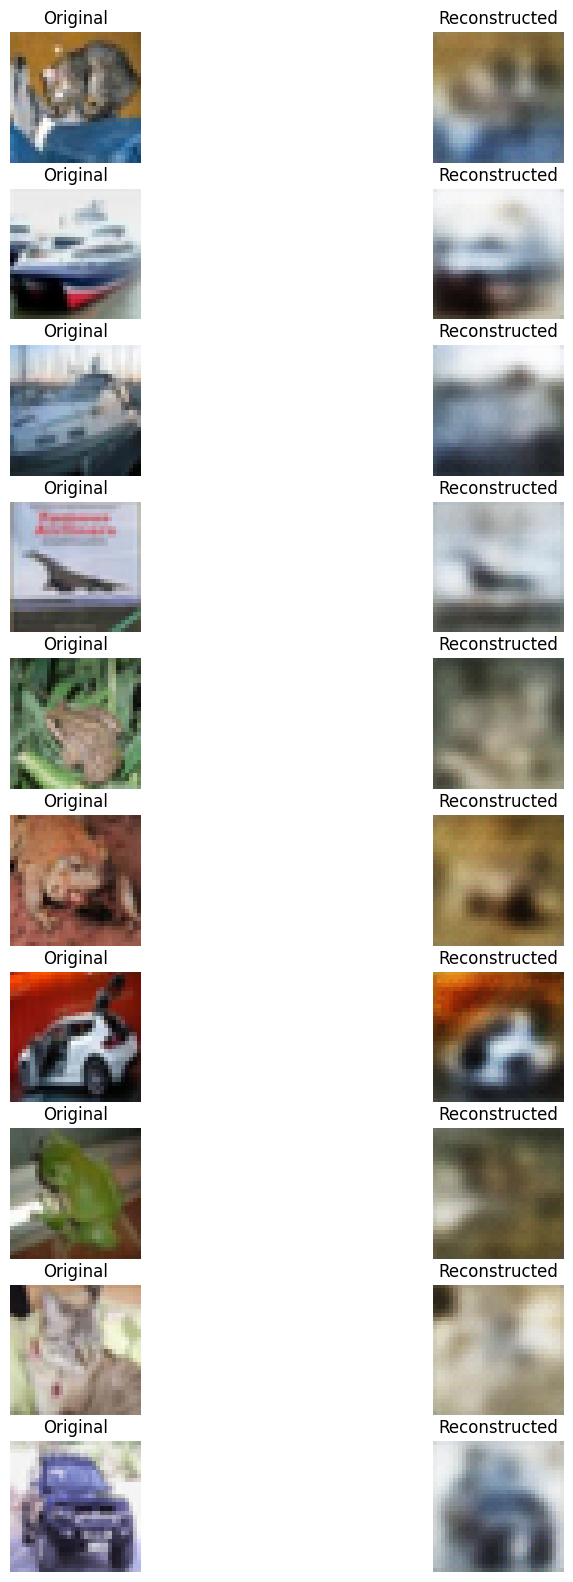

Epoch 2, Loss: 0.03794459863305092
Test Reconstruction Loss: 0.0347


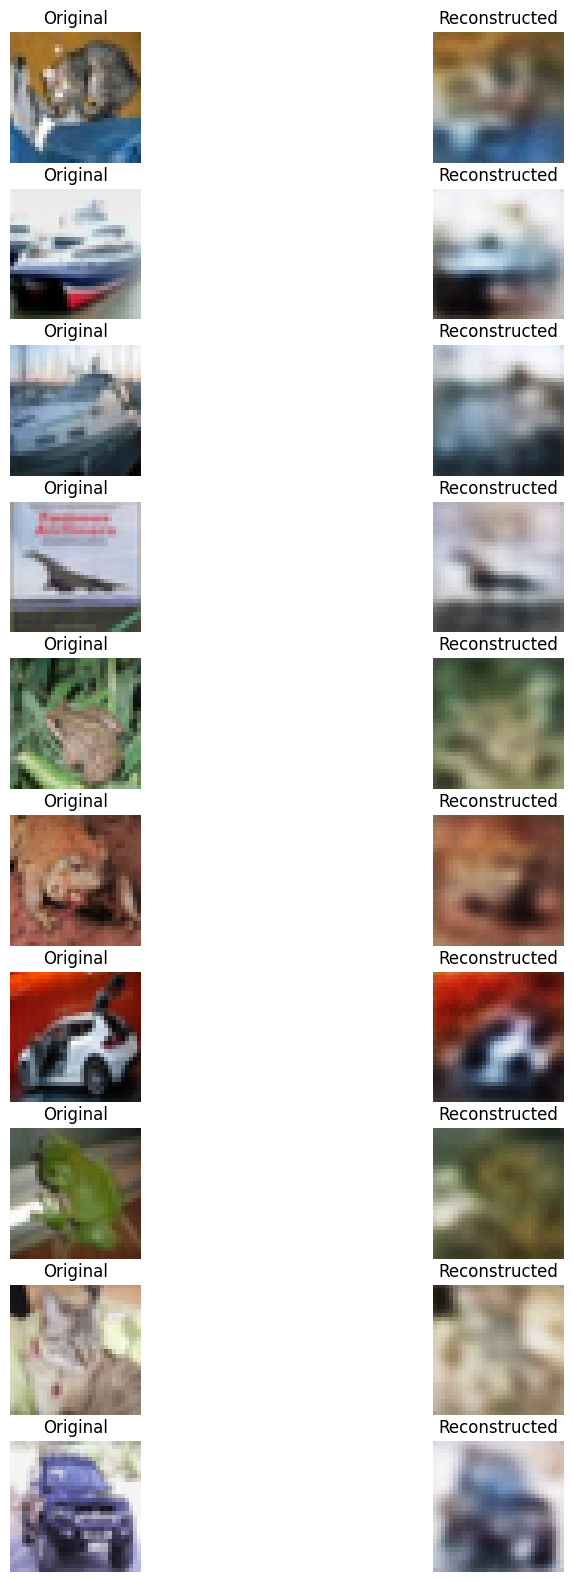

Epoch 3, Loss: 0.030609097580611706
Test Reconstruction Loss: 0.0301


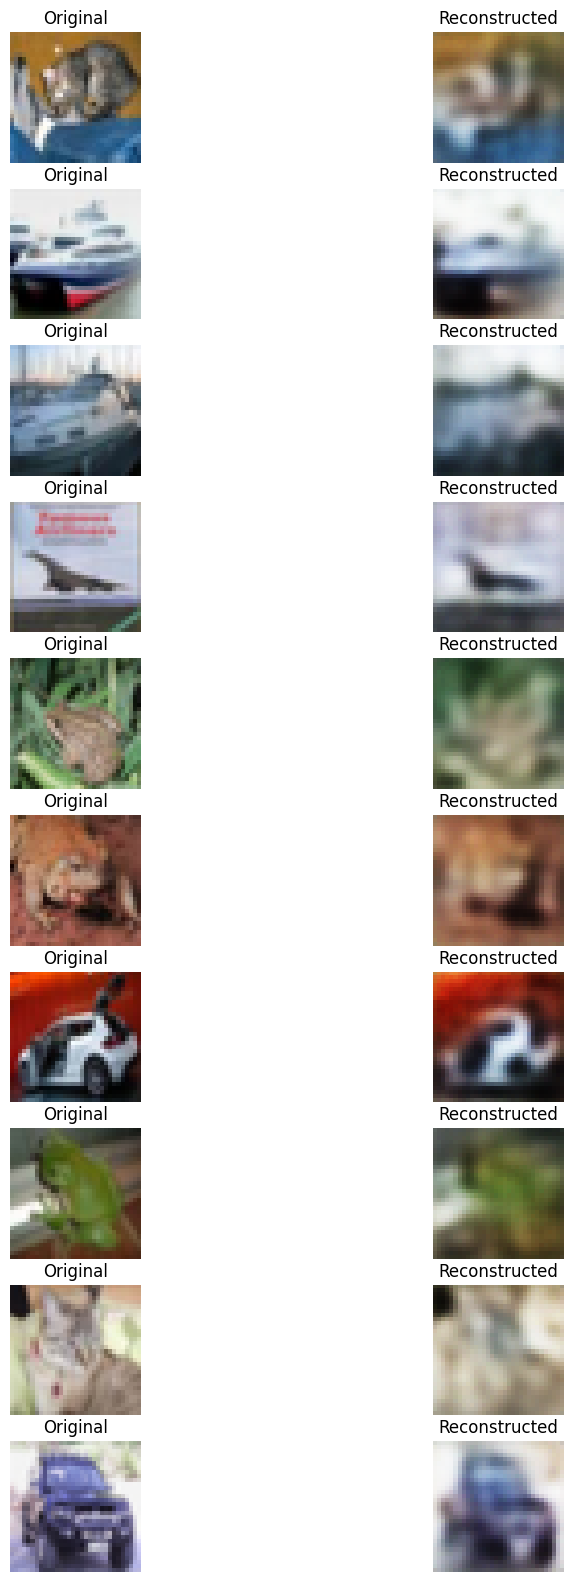

Epoch 4, Loss: 0.027002237728983164
Test Reconstruction Loss: 0.0290


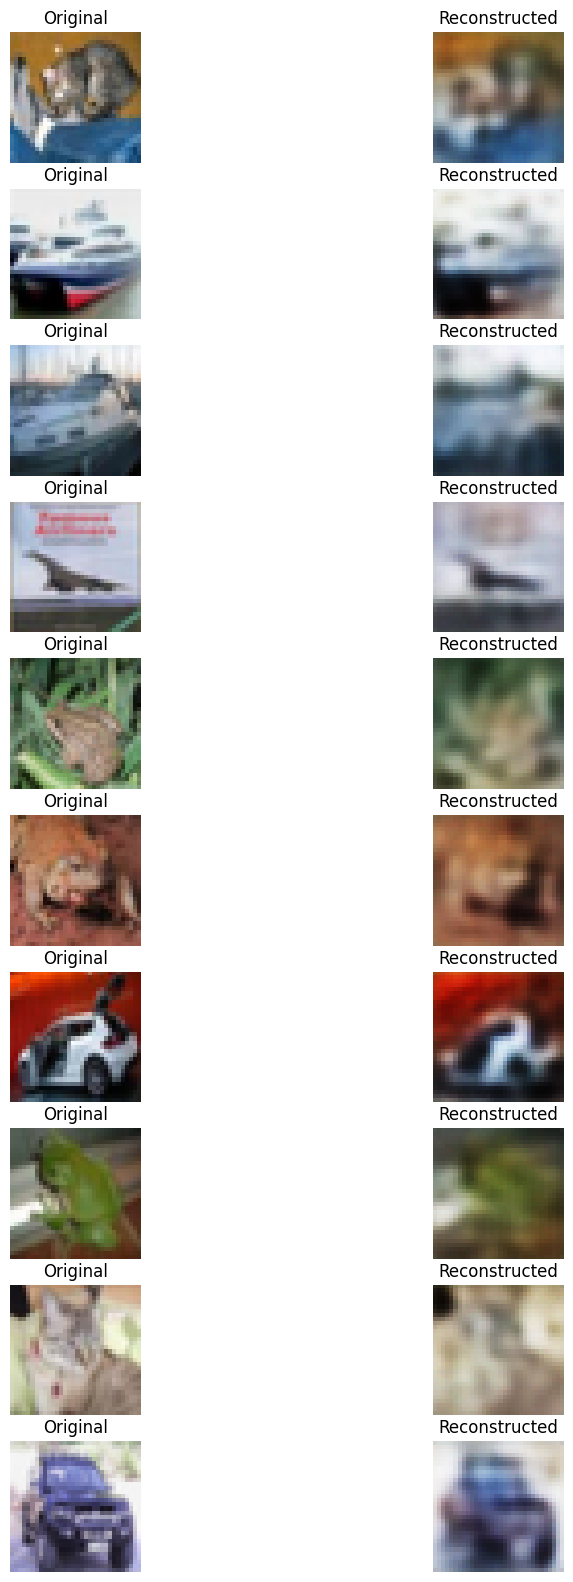

Epoch 5, Loss: 0.024900336463004352
Test Reconstruction Loss: 0.0266


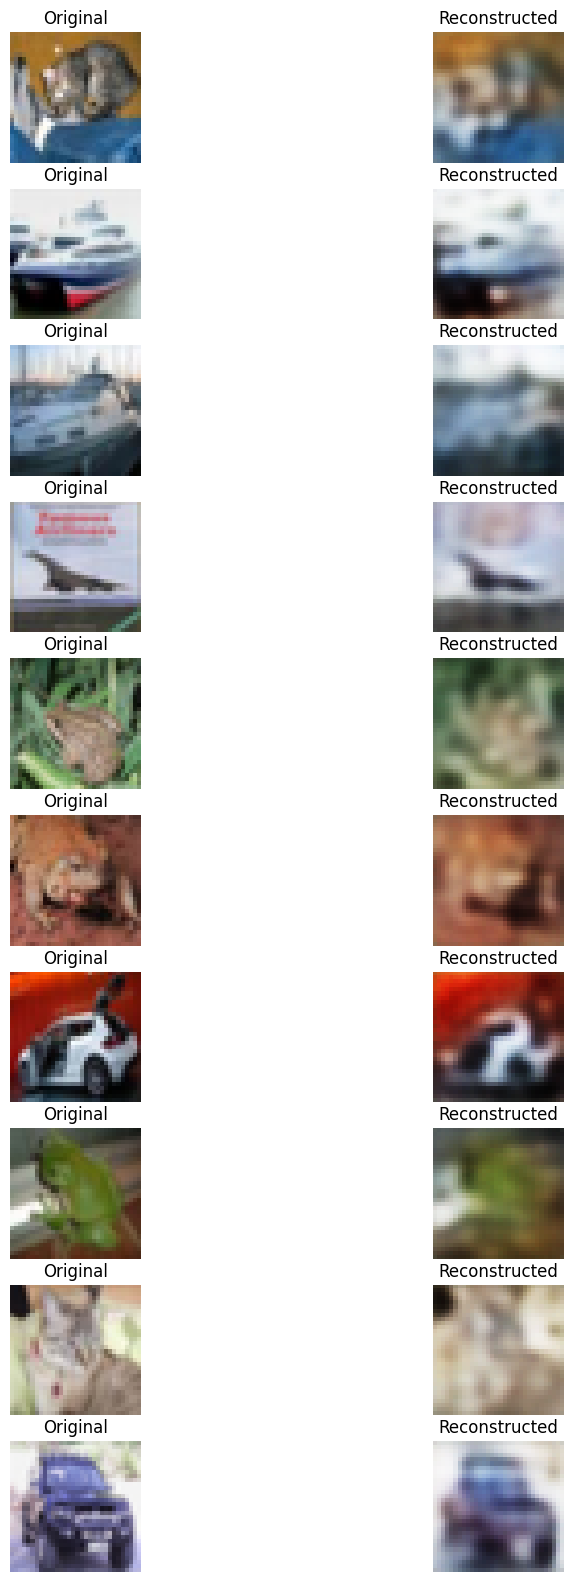

In [8]:
train_size = int(0.8 * len(train_dataset))
val_size   = len(train_dataset) - train_size

train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Create DataLoader 
dl_train = DataLoader(train_dataset, batch_size=16, shuffle=True)
dl_test  = DataLoader(test_dataset, batch_size=16, shuffle=False)
dl_val   = DataLoader(val_dataset, batch_size=16, shuffle=False)

im_size = train_dataset[0][0].shape

# Initialize the autoencoder and the optimizer
latent_dim = 128
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder = EncoderCIFAR(in_channels=im_size[0], latent_dim=128)
decoder= DecoderCIFAR(latent_dim=128, out_channels=im_size[0])
#autoencoder = AutoEncoderCIFAR(latent_dim).to(device)
criterion = torch.nn.MSELoss()
#optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-3)
optimizer = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=1e-3)

# Training self-supervised 
num_epochs = 5
for epoch in range(num_epochs):
    epoch_loss = 0.0
    encoder.train()
    decoder.train()
    for data in dl_train:
        images, _ = data
        images = images.to(device)
        optimizer.zero_grad()
        
        latent = encoder(images)
        reconstructed = decoder(latent)
        #reconstructed, _ = autoencoder(images)
        loss = criterion(reconstructed, images)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    avg_epoch_loss = epoch_loss / len(dl_train) 
    print(f"Epoch {epoch+1}, Loss: {avg_epoch_loss}")

    # Plot reconstructions after training
    with torch.no_grad():
        test_images, _ = next(iter(dl_test))
        test_images = test_images.to(device)
        latent = encoder(test_images)
        reconstructed = decoder(latent)
        #reconstructed, _ = autoencoder(test_images)
        
        reconstruction_loss = criterion(reconstructed, test_images)
        print(f"Test Reconstruction Loss: {reconstruction_loss.item():.4f}")
        plot_reconstruction(test_images, reconstructed)
        

In [18]:
# Function to plot images with labels and predictions
def plot_images_with_labels(images, true_labels, predicted_labels, class_names, num_images=10):
    images = images.cpu().detach().numpy()  # Convert to numpy (on CPU)
    true_labels = true_labels.cpu().detach().numpy()  # True labels
    predicted_labels = predicted_labels.cpu().detach().numpy()  # Predicted labels
    
    num_images = min(num_images, images.shape[0])  # Ensure we don't exceed batch size
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))

    for i in range(num_images):
        ax = axes[i]
        ax.imshow(np.transpose(images[i], (1, 2, 0)))  # Reorder to (H, W, C)
        ax.set_title(f"True: {class_names[true_labels[i]]}\nPred: {class_names[predicted_labels[i]]}")
        ax.axis('off')  # Hide axes

    plt.show()

In [19]:
for param in encoder.parameters(): # Freeze encoder weights
    param.requires_grad = False

In [20]:
# Initialize the classifier and optimizer
classifier = ClassifierCIFAR(latent_dim=128, num_classes=10).to(device)
classifier_optimizer = torch.optim.Adam(classifier.parameters(), lr=1e-3)
criterion_classifier = torch.nn.CrossEntropyLoss()

# Training loop for classifier
num_epochs = 10
for epoch in range(num_epochs):
    classifier.train()  # training mode
    epoch_loss = 0.0
    correct = 0
    total = 0

    for data in dl_train:
        images, labels = data
        images, labels = images.to(device), labels.to(device)

        # Get latent representation from the encoder 
        with torch.no_grad():
            latent = encoder(images)

        classifier_optimizer.zero_grad() 
        outputs = classifier(latent) 

        loss = criterion_classifier(outputs, labels)  # Cross-Entropy Loss
        loss.backward()  # Backpropagate
        classifier_optimizer.step()  # Update classifier weights

        epoch_loss += loss.item()  # Accumulate loss
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    avg_loss = epoch_loss / len(dl_train)
    accuracy = 100 * correct / total

    print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")


Epoch 1, Loss: 1.3086, Accuracy: 53.85%
Epoch 2, Loss: 1.2518, Accuracy: 56.18%
Epoch 3, Loss: 1.2396, Accuracy: 56.30%
Epoch 4, Loss: 1.2244, Accuracy: 56.70%
Epoch 5, Loss: 1.2202, Accuracy: 57.08%
Epoch 6, Loss: 1.2106, Accuracy: 57.17%
Epoch 7, Loss: 1.2058, Accuracy: 57.45%
Epoch 8, Loss: 1.2028, Accuracy: 57.57%
Epoch 9, Loss: 1.1928, Accuracy: 57.85%
Epoch 10, Loss: 1.1893, Accuracy: 57.92%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.84313726..0.9372549].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.92941177].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9137255].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8117647..0.84313726].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.94509804..1.0].
Clipping input data to 

Test Loss: 1.1096
Test Accuracy: 59.80%


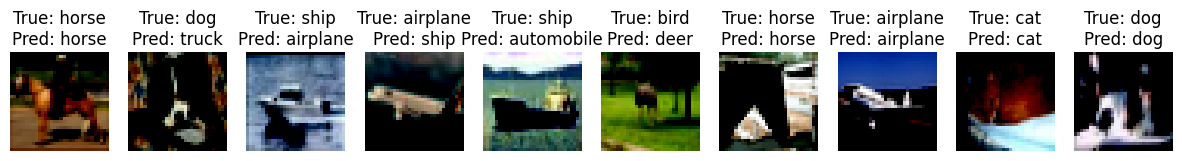

In [22]:
# Test the classifier on the test set
classifier.eval()  # Set classifier to evaluation mode
test_loss = 0.0
correct = 0
total = 0
with torch.no_grad():
    for data in dl_test:
        images, labels = data
        images, labels = images.to(device), labels.to(device)

        latent = encoder(images)
        outputs = classifier(latent)

        # Calculate loss
        loss = criterion_classifier(outputs, labels)
        test_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Test Loss: {test_loss / len(dl_test):.4f}")
print(f"Test Accuracy: {accuracy:.2f}%")


# Visualize the images along with their true and predicted labels
plot_images_with_labels(images, labels, predicted, class_names, num_images=10)


In [23]:
###Classification-Guided Encoding###

encoder = EncoderCIFAR(in_channels=im_size[0], latent_dim=128)
classifier = ClassifierCIFAR(latent_dim=128, num_classes=NUM_CLASSES).to(device)

optimizer = torch.optim.Adam(list(encoder.parameters()) + list(classifier.parameters()), lr=1e-3)
criterion_classifier = torch.nn.CrossEntropyLoss()

# Training loop 
num_epochs = 10
for epoch in range(num_epochs):
    encoder.train()  # training mode
    classifier.train()
    epoch_loss = 0.0
    correct = 0
    total = 0

    for data in dl_train:  
        images, labels = data
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        latent = encoder(images)  
        outputs = classifier(latent)

        # Compute loss
        loss = criterion_classifier(outputs, labels)
        loss.backward() 
        optimizer.step()  

        epoch_loss += loss.item()  
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    avg_epoch_loss = epoch_loss / len(dl_train)  
    accuracy = 100 * correct / total
    print(f"Epoch {epoch+1}, Loss: {avg_epoch_loss:.4f}, Accuracy: {accuracy:.2f}%")



Epoch 1, Loss: 1.5785, Accuracy: 43.13%
Epoch 2, Loss: 1.2464, Accuracy: 56.27%
Epoch 3, Loss: 1.0643, Accuracy: 63.14%
Epoch 4, Loss: 0.9281, Accuracy: 68.14%
Epoch 5, Loss: 0.8139, Accuracy: 72.05%
Epoch 6, Loss: 0.7161, Accuracy: 75.58%
Epoch 7, Loss: 0.6249, Accuracy: 78.77%
Epoch 8, Loss: 0.5477, Accuracy: 81.50%
Epoch 9, Loss: 0.4843, Accuracy: 83.47%
Epoch 10, Loss: 0.4264, Accuracy: 85.42%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.84313726..0.9372549].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.92941177].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9137255].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8117647..0.84313726].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.94509804..1.0].
Clipping input data to 

Test Loss: 0.9525
Test Accuracy: 70.95%


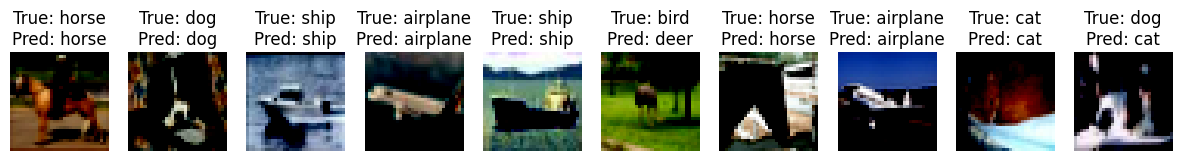

In [24]:
# Evaluate the classifier on the test set
encoder.eval()  # Set encoder and classifier to evaluation mode
classifier.eval()
test_loss = 0.0
correct = 0
total = 0

with torch.no_grad():
    for data in dl_test:
        images, labels = data
        images, labels = images.to(device), labels.to(device)

        # Get latent representation from the encoder
        latent = encoder(images)  # Encoder only

        # Classifier output
        outputs = classifier(latent)

        # Calculate loss
        loss = criterion_classifier(outputs, labels)
        test_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = 100 * correct / total
print(f"Test Loss: {test_loss / len(dl_test):.4f}")
print(f"Test Accuracy: {test_accuracy:.2f}%")
# Visualize the images along with their true and predicted labels
plot_images_with_labels(images, labels, predicted, class_names, num_images=10)
